# Mathematics of replicated sampling (RS)
Below is the expression for likelihood and log-likelihood.
\begin{align}
    p(y|X,\theta)   &= \mathcal{N}(m,K_y(\theta,k_i)) \\
                    &= (2\pi)^{-D/2}|K_y(\theta,k_i)|^{1/2}\exp\left(-\frac{1}{2}(y-m)^TK_y(\theta,k_i)^{-1}(y-m)\right)
\end{align}

And the log-likelihood:

\begin{align}
    \ln p(y|X,\theta,k_i) &= -\frac{D}{2}\ln 2\pi - \frac{1}{2}\ln |K_y(\theta,k_i)|- \frac{1}{2}(y-m)^TK_y(\theta,k_i)^{-1}(y-m)
\end{align}

Here $K_y(\theta,k_i) = K(\theta,k_i) + \sigma_n^2 I$. Also we use the squared error (SE) kernel.

\begin{align}
    k(x_i,x_j) &= \sigma_0 \exp\left(-\frac{(x_i-x_j)^2}{2\ell^2}\right)
\end{align}

The hyperparameters are $\sigma_n^2$, $\sigma_0$, and $\ell$. They represent noise, amplitude, and length-scale respectively. We refer to $- \frac{1}{2}(y-m)^TK_y(\theta,k_i)^{-1}(y-m)$ as term $A$ and $-\frac{1}{2} \ln |K_y(\theta,k_i)|$ as term $B$. The term containing $\pi$ does not vary $w.r.t.$ hyperparameters and will not be condsidered.

*note:* please excuse notational sloppiness, I was trying to be quick

## Investigating term $A$
Term $A$ is in the quadratic form $x^TAx$ where $x=(y-m)$ and $A=\left(K(\theta,k_i)+\sigma_n^2\right)^{-1}$. The quadratic form can be expressed as a double sum:

$$ x^TAx = \sum_{i=1}^n\sum_{j=1}^{n} a_{ij}x_ix_j $$

It is important to recall that $A$ is defined as an inverse of $K_y^{-1}$. When considering RS the matrix becomes ill-conditioned and cannot be inverted if $\sigma_n^2 = 0$. If $K_y$ is singular and $\sigma_n^2$ is small then the inverse matrix has extremely large values and that makes this term dominate log-likelihood equation (see figures at the bottom).

### Some numerical examples

In [1]:
### lets do some numerical examples
include("testing_rank_stuff.jl");
fxn = forrester
acq_noise = 1.5
function obj_fxn(x::Int)
    ret_val = fxn(x,add_noise=true,noise=Normal(0.0,acq_noise))
    return ret_val[1], ret_val[2], ret_val[3]
end;
function obj_fxn(x::Array)
    ret_val = fxn(x,add_noise=true,noise=Normal(0.0,acq_noise))
    return ret_val
end;

function RS(xs,num)
    repmat(xs,num,)
end;

In [2]:
(xs,ys,range)= obj_fxn(1)
kern = SE(0.0,0.0)
mZero = MeanZero()
logObsNoise = 0.0
gp1 = GP(xs,ys,mZero,kern,logObsNoise)
xs2 = RS(xs,2)
gp2 = GP(xs2,obj_fxn(xs2),mZero,kern,logObsNoise);

#### A Single sample from a noisy Forrester function

In [3]:
function display_vals(gp)
    println("x:")
    println(gp.X)
    println("K:")
    k1 = cov(gp.k,gp.X) 
    println(k1)
end
function display_inv(gp;noise=0.0)
    k1 = cov(gp.k,gp.X) 
    kn = k1 + noise*eye(similar(k1))
    @printf("Condition: %0.2e\n",cond(kn))
    print("K^-1:")
    return inv(kn)    
end
println("SS example:")
display_vals(gp1)
display_inv(gp1)

SS example:
x:
[0.864744]
K:
[1.0]
Condition: 1.00e+00
K^-1:

1×1 Array{Float64,2}:
 1.0

#### Now we replicate the above sample once. The covariance isn't invertible as is so we have to make $\sigma_n^2 > 0$

In [4]:
println("replicating the above example once")
println("have to add noise to invert")
display_vals(gp2)
sign = 1e-8
@printf("\sigma_n^2= %0.2e\n",sign)
display_inv(gp2,noise=sign)

replicating the above example once
have to add noise to invert
x:
[0.864744 0.864744]
K:
[1.0 1.0; 1.0 1.0]
sigma_n^2= 1.00e-08
Condition: 2.00e+08
K^-1:

2×2 Array{Float64,2}:
  5.0e7  -5.0e7
 -5.0e7   5.0e7

In [5]:
println("adding more noise")
sign = 1e-2
@printf("\sigma_n^2= %0.2e\n",sign)
display_inv(gp2,noise=sign)

adding more noise
sigma_n^2= 1.00e-02
Condition: 2.01e+02
K^-1:

2×2 Array{Float64,2}:
  50.2488  -49.7512
 -49.7512   50.2488

## Investigating term $B$
### Some properties of the determinant
A couple properties that seemed relevant to me:

* $\det(A) = 0$ if any row or column is 0
* $\det(A) = 0$ if any two rows or columns are identical (or are expressed as linear combinations)

The log-likelihood becomes exactly 0 if the determinant is zero, which will be the case in RS.... if $\sigma_n^2=0$.

#### So, we want $|K_y(\theta,k_i) \neq 0|$
It is interesting to note that if $\sigma_n^2$ weren't a scalar then this would be the formulation for the eigenvalues *except* we don't solve for the quantity to be equal to zero, but want it larger to increase the model likelihood.

#### There are bounds on the determinant:

* $tr(I-A^-1) \leq \log \det(A) \leq tr(A-I)$

But they don't seem to be very useful in practical application

In [6]:
function display_det(gp;noise=0.0)
    k1 = cov(gp.k,gp.X) 
    kn = k1 + noise*eye(similar(k1))
    detk = det(kn)
    lbnd = exp(trace(eye(similar(kn))-kn^-1))
    @printf("det(K): %0.2e --- \sigma_n^2= %0.2e, lbnd=%0.2e\n", detk, noise,lbnd)
end
println("For the SS case:")
display_det(gp1)
println("\nFor the RS case with low noise:")
display_det(gp2,noise=1e-8)
println("\nFor the RS case with higheer noise:")
display_det(gp2,noise=1e-2)

For the SS case:
det(K): 1.00e+00 --- sigma_n^2= 0.00e+00, lbnd=1.00e+00

For the RS case with low noise:
det(K): 2.00e-08 --- sigma_n^2= 1.00e-08, lbnd=0.00e+00

For the RS case with higheer noise:
det(K): 2.01e-02 --- sigma_n^2= 1.00e-02, lbnd=1.67e-43


### The bigger picture
We can see that the main bound on the determinant goes to zero when the diagonal terms in $A^{-1}$ are large. When RS is used $\sigma_n^2$ has to be greater than 0 in order to invert, the smaller $\sigma_n^2$ is the smaller the determinant will be.

In my tests I have found that the effect of term $B$ is dwarved by that of term $A$. See the figures below.

## Some numerical tests
I haven't been able to figure out a nice mathematical way to express what is happening. There are so many different variables...

Following are plots of the likelihood as each individual hyperparameters is varied. While a single hyperparameter is being varied the others are fixed to $\sigma_n^2=\exp(-1e4)\approx0$, $\sigma_0=1$, and $\ell=1$. Below notice how $\sigma_n^2$ dominates the likelihood value.

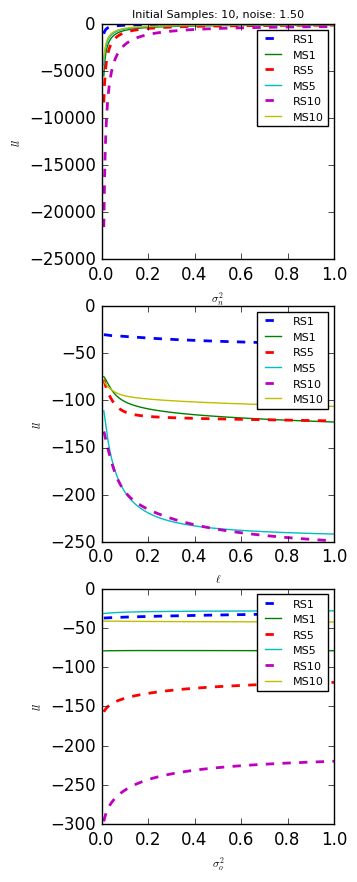

In [7]:
function_test(obj_fxn,10,acq_noise);